# Interactive Linear Spectral Mixture Analysis in Python

This notebook gives an overview to the use of the `unmixing` library for interactive linear spectral mixture analysis (LSMA) in pure Python.

## Stacking and Masking an Input Raster

Here, we use an example of Landsat imagery from the Detroit Metropolitan Statistical Area, a Landast 5 TM scene (WRS-2 row 20, path 31) from July 15, 2008: `LT50200312008197`.

**The first step is to take the EOS-HDF file we downloaded and stack it as a NumPy array.** As a NumPy array, we can perform a number of mathematical transformations directly to the data, stored as a rectangular array.

We use `utils.stack_hdf_as_array()` and, as the file is an EOS-HDF, we need to indicate with `bands` we want to include in the stack.

In [3]:
from unmixing.utils import stack_hdf_as_array

raster_path = '/home/arthur/Desktop/LT50200312008197-SC20170310150028/LT50200312008197GNC01.hdf'

# Create a stacked (multi-band) NumPy array
stack, gt0, wkt = stack_hdf_as_array(raster_path, bands=(1,2,3,4,5,7))

The `stack_hdf_as_array()` function returns three arguments; in order, the names I've chosen to give them and what they are:

- `stack`, the `numpy.ndarray` instance that corresponds to my multi-band raster;
- `gt0`, what GDAL calls the "geotransform;" it describes the corner coordinates, pixel size, etc. of my raster;
- `wkt`, the Well-Known Text (WKT) string describing the projection of the raster.

**Because geotransforms and WKT projection strings are common currency in the `unmixing` library, it's worth getting more familiar with them.** I've called the geotransform `gt0` because we're going to clip it later, thus obtaining a new, different geotransform.

In [4]:
gt0

(148785.0, 30.0, 0.0, 4737915.0, 0.0, -30.0)

In [5]:
wkt

'PROJCS["UTM Zone 17, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not specified (based on WGS 84 spheroid)",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["Meter",1]]'

As we can see, the `gt0` and `wkt` variables contain strings. The `wkt` string describes the UTM 17N projection that the data are stored in.

**Next, we want to apply the cloud mask/ quality-assurance band to the data to mask out any "bad" pixels.** The USGS provides a quality-assurance band derived from [CFmask](https://code.google.com/p/cfmask/). We have a function to apply this mask to an input raster, filling in the "bad" pixels with a chosen NoData value.

We open the mask as an array using `utils.as_array()`. The masking function `utils.cfmask()` accepts either a NumPy array or a `gdal.Dataset`, so it doesn't matter which we provide (we can get a `gdal.Dataset` using `gdal.Open()`). **The real trick with an HDF is to get the CFMask band, which requires a special syntax.** EOS-HDF files contain bands with names like, e.g.,:

- `HDF4_EOS:EOS_GRID:"/path/to/filename.hdf":Grid:sr_band1` (Surface reflectance band 1)
- `HDF4_EOS:EOS_GRID:"/path/to/filename.hdf":Grid:sr_band2` (Surface reflectance band 1)
- `HDF4_EOS:EOS_GRID:"/path/to/filename.hdf":Grid:cfmask` (The CFMask band)

In [4]:
from unmixing.utils import as_array, cfmask

# This is the syntax for a specific band in an EOS-HDF file
mask, gt_mask, wkt_mask = as_array('HDF4_EOS:EOS_GRID:"%s":Grid:cfmask' % raster_path)

# Following convention, we'll -9999 as the NoData value.
masked_stack = cfmask(stack, mask, nodata=-9999)
mask = stack = None

By setting `mask = stack = None`, we can trash both the mask and the original raster in order to reclaim some memory.

### Other Masking Considerations

**We can also mask out saturated pixels** (pixels that saturate the detector and take on the maximum value that can be encoded). Saturation can occur, for example, in sun glint. For surface reflectance images that are going to be analyzed with LSMA, this can improve our interpretation of the mixing space, as we'll see later.

In [5]:
from unmixing.utils import mask_saturation

masked_stack = mask_saturation(masked_stack, nodata=-9999)

We might also want to mask out inland water bodies. Density slicing of TM/ETM+ Band 5 has been shown to be very good at detecting inland water bodies (Frazier et al., 2000), so we'll:

1. Create a mask layer based on density slicing, and;
2. Apply it to our stacked raster.

I'll assume, based on inspection of the Band 5 histogram, that water pixels are those with reflectance in Band 5 less than or equal to 1000. A "less-than-or-equal" relationship (`rel` argument) is the default for the `density_slice()` function.

In [6]:
from unmixing.utils import density_slice, binary_mask

# Generate a mask of pixels with Band 5 reflectance <= 1000 
# Band 5 is layer number 4 in our NumPy array
water_mask = density_slice(masked_stack[4, ...], threshold=1000)

# Apply the water mask to our stacked raster
masked_stack = binary_mask(masked_stack, water_mask)

The `utils.binary_mask()` function is a general purpose function that applies a mask (a raster of ones and zeroes, the second argument) to an input raster (the first argument).

### Clipping a Raster

The `unmixing` library no longer has a built-in clipping function; there are plenty of other free tools that can clip a raster given a feature layer as a mask or cutline, including the GDAL/OGR command line tools, [rasterio](https://pypi.org/project/rasterio/), and QGIS. This example proceeds here assuming the raster has already but clipped to the desired area.

---
## Noise Mitigation and Dimensionality Reduction

Let's take a look at the image we're going to be working with.

In [71]:
from unmixing.utils import as_array
lt5_image, gt, wkt = as_array('detroit.tiff')
lt5_image.shape

(6, 707, 1032)

The image has 6 Landsat TM bands: blue, green, red, NIR, SWIR1, and SWIR2. There are 707 rows and 1032 columns.

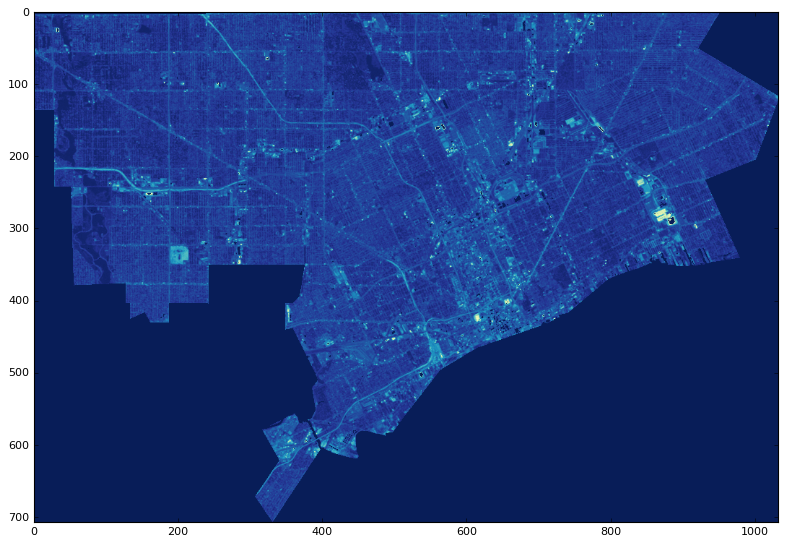

In [72]:
from matplotlib import pyplot as plt, cm
%matplotlib inline

# Look at layer 3 (Band 4, the NIR band)
preview = lt5_image
preview[preview == -9999] = 0 # Remap any NoData values to zero

plt.figure(figsize = (12, 12))
plt.imshow(preview[2,:,:], cmap=cm.YlGnBu_r)
plt.show()

**In LSMA, it's common to use dimensionality reduction/ ordination techniques before unmixing.** Here, we apply the minimum noise fraction (MNF) transformation to our raster. This transformation is similar to a principal components analysis (PCA) transformation but orders components by their signal-to-noise ratio, rather than variance. The MNF transform allows us to:

- Estimate the inherent dimensionality of the data, and,
- Improve the signal-to-noise ratio of the first few components.

In [73]:
from unmixing.transform import mnf_rotation

hsi_post_mnf = mnf_rotation(lt5_image)

Note that the MNF-transformed image is a a 3-dimensional array with shape ($m$ x $n$ x $p$) where $p$ is the number of bands, and $m$ and $n$ are the number of columns and rows, respectively. In hyperspectral imaging applications, this is called a __hyperspectral imaging (HSI) cube__.

In [74]:
hsi_post_mnf.shape

(1032, 707, 6)

To convert between a typical NumPy raster array ($p$ x $n$ x $m$) and an HSI cube, we take the transpose of the matrix, which can accessed as the attribute `T` on any NumPy array.

In [75]:
hsi_post_mnf.T.shape

(6, 707, 1032)

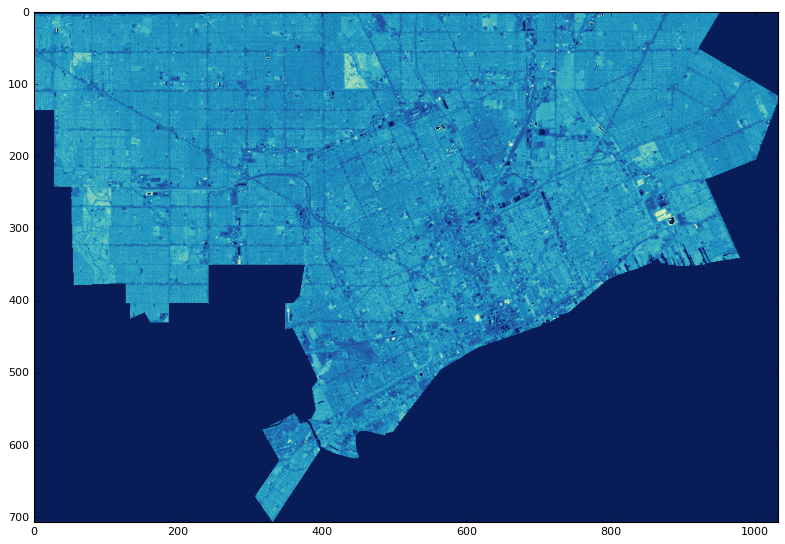

In [76]:
plt.figure(figsize=(12,12))

# We can convert an HSI cube to a regular raster by taking its transpose, hsi.T
plt.imshow(hsi_post_mnf.T[0,...], cmap=cm.YlGnBu_r)
plt.show()

### Estimating the Dimensionality of the Data

Because Landsat bands are highly correlated with one another (as cited by Lu and Weng 2004), the MNF transformation, like a PCA rotation, condenses the same amount of "information" (not necessarily in the statistical sense) into a fewer number of bands. Thus, a 6-band TM/ETM+ image (excluding the thermal infrared band), may not necessarily require 6 bands to convey the same amount of "information."

A more accurate estimate of the dimensionality of an image can be obtained from a plot of the eigenvalues of the covariance matrix (Small 2004). This is similar to a __scree plot__ in exploratory factor analysis. From this plot, below, we can see that the first (zeroth) MNF component explains more than 99% of the variance; the second component explains about 0.05%. This is an extreme example, probably because the image area is so small. In general, the inherent dimensionality of a typical Landsat scene is three (3), i.e., "99% of the spectral variance can be represented in a 3-dimensional mixing space" of the first few MNF/PCA components (Small and Milesi, 2013).

In [95]:
import numpy as np
import pysptools.util as sp_utils
from unmixing.lsma import ravel_and_filter

# Filter out NoData values from the MNF-transformed image
hsi_post_mnf_filtered = ravel_and_filter(np.where(lt5_image == -9999, -9999, hsi_post_mnf.T))

# Obtain the covariance matrix
cov_m = sp_utils.cov(hsi_post_mnf_filtered)

# Compute the eigenvalues, sort them, reverse the sorting
eigenvals = np.sort(np.linalg.eig(cov_m)[0])[::-1]
eigenvals_p = np.power(eigenvals, 2) / sum(np.power(eigenvals, 2))
list(map(lambda x: round(x, 5), eigenvals_p.tolist()))

[0.99946, 0.00049, 5e-05, 0.0, 0.0, 0.0]

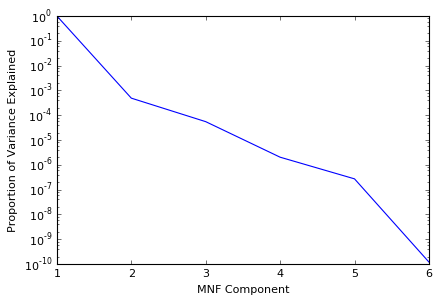

In [93]:
plt.plot(range(1, 7), eigenvals_p)
plt.yscale('log', basey = 10)
plt.xlabel('MNF Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

We can confirm that the first two MNF components contain the vast majority of the signal in the image by visualizing each of, say, the first four components.
The third and fourth components appear to be largely noise.

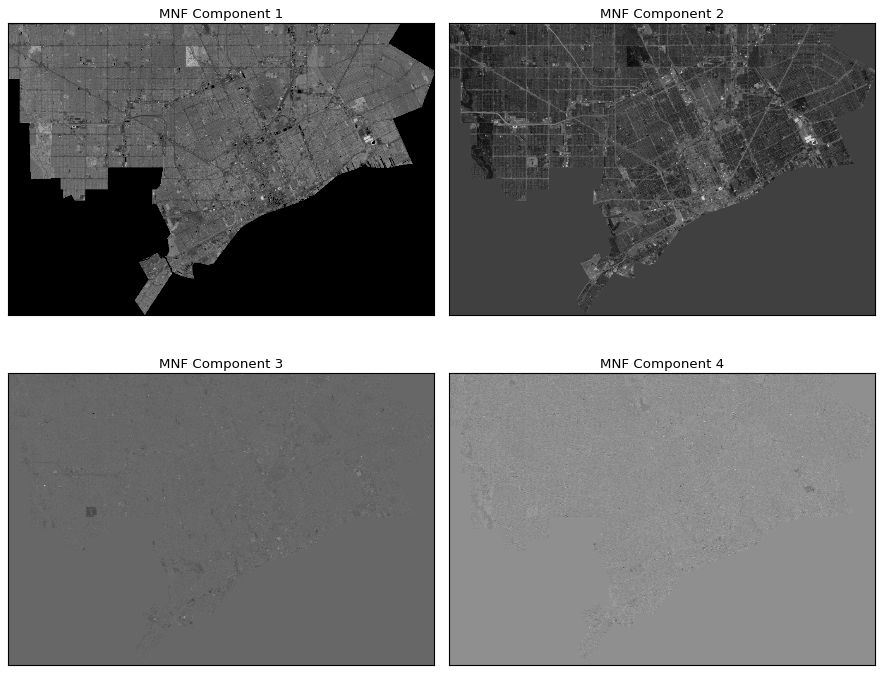

In [94]:
fig = plt.figure(figsize = (16, 16))
fig.subplots_adjust(wspace = -0.2)
for i in range(1, 5):
    ax = fig.add_subplot(320 + i, title = 'MNF Component %d' % i)
    ax.imshow(hsi_post_mnf.T[i - 1,:,:], cmap = cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

---
## Time Series Analysis

If we wish to use LSMA on a time series of images, it is essential that the images are comparable. Starting with surface reflectance (SR) data mitigates much of the problems with cross-image comparison, however, there are still differences in brightness between even consecutive Landsat scenes. Radiometric rectification is one of the tools available for mitigating brightness differences between images and `unmixing` provides an implementation of Hall's (1991) method using pseudo-invariant features. The first step is to identify the reference image, which, among other criteria, should be the image in the series with the highest dynamic range.

In [97]:
from unmixing.lsma import report_raster_dynamic_range

report_raster_dynamic_range('detroit.tiff')

5385.00 (32310 s.d.) -- detroit.tiff                            


In [98]:
from unmixing.lsma import hall_rectification
help(hall_rectification)

Help on function hall_rectification in module unmixing.lsma:

hall_rectification(reference, subject, out_path, ref_set, sub_set, dd=False, nodata=-9999, dtype=<class 'numpy.int32'>, keys=('High/Bright', 'Low/Dark'))
    Performs radiometric rectification after Hall et al. (1991) in Remote
    Sensing of Environment. Assumes first raster is the reference image and
    that none of the targets are NoData pixels in the reference image (they
    are filtered out in the subject images). Arguments:
        reference   The reference image, a gdal.Dataset
        subject     The subject image, a gdal.Dataset
        out_path    Path to a directory where the rectified images should be stored
        ref_set     Sequence of two sequences: "bright" radiometric control set,
                    then "dark" radiometric control set for reference image
        sub_set     As with ref_set, a sequence of sequences (e.g., list of two
                    lists): [[<bright targets>], [<dark targets]]
     

---
## Endmember Selection

For the purpose of radiometric rectification but, more importantly, for the ultimate goal of describing the image's mixed pixels in terms of their abundance of spectrally "pure" materials in the scene, we need to identify endmembers. Endmembers are the "pure" materials of which every mixed pixel contains some fractional abundance, e.g., a park that contains both vegetation (as grass and tress) and impervious surface (as sidewalks) endmembers.

Some LSMA applications use data collected by field spectroradiometers to characterize the spectral reflectance of known ground materials. However, LSMA studies are increasingly using so-called "image endmembers," or endmembers found in the multispectral image of interest, because of the difficulty in producing relevant field spectra. Because ideal image endmembers lie at the corners of the mixing space and are spectrally "pure" features, a number of algorithms have been developed to select candidate endmembers by examination of the mixing space. The `pysptools` library, a dependency of `unmixing`, provides some of the better-known algorithms for automatically selecting endmembers.

The pixel purity index (PPI), for instance, creates multiple random projections of the mixing space, counting how many times each pixel appears "extreme" across these projections. **Here, we attempt to find three endmembers in the MNF mixing space using PPI.**

In [99]:
import pysptools.eea as sp_extract

ppi = sp_extract.PPI()

# Try to extract 3 endmembers using the PPI algorithm with 2,000 random projections
members = ppi.extract(hsi_post_mnf[...,0:3], 3, numSkewers = 2000)

This algorithm gives us back the MNF spectra.

In [100]:
members

array([[ 206.89477539,   11.89373016,   -2.81698704],
       [ 193.34474182,   23.73165703,    0.91541803],
       [  18.02550125,   18.53506851,   48.29753494]], dtype=float32)

However, this isn't so useful. We have no idea where these spectra came from. For this, we need to ask for the "indices" of the endmember targets. These are the row, column coordinates within our HSI data cube.

In [101]:
ppi.get_idx()

[(100, 255), (295, 881), (273, 89)]

`unmixing` provides friendlier tools for working with potential endmembers. By providing the spatial reference information (`gt` and `wkt`), we can convert the coordinates in pixel space to coordinates in geographic space (here, as longitude and latitude pairs).

In [102]:
from unmixing.utils import pixel_to_xy

# Switch pixel coordinates from (p, m, n) to (n, m, p)
coords = [(y, x) for x, y in ppi.get_idx()]

pixel_to_xy(coords, gt = gt, wkt = wkt, dd = True)

[(-83.19390127923305, 42.418653662396636),
 (-82.96413548458621, 42.37013999241329),
 (-83.25271374437501, 42.37077442081192)]

---
## Visualization of the Mixing Space

Despite the popularity and ubiquity of automated endmember induction algorithms like PPI and NFINDR, these often fail to identify reasonable endmembers in multispectral images. They tend to be sensitive to outliers like orange-colored roofs (which closely resemble ideal soil) and high-albedo targets like swimming pools.

We can visualize the mixing space with the `unmixing.visualize` module, for the purpose of identifying where, e.g., PPI-induced endmembers are located, or for the purpose of finding endmembers manually. For now, `unmixing.visualize.FeatureSpace` only works with raster files on disk, so we first need to dump our clipped raster array to a file.

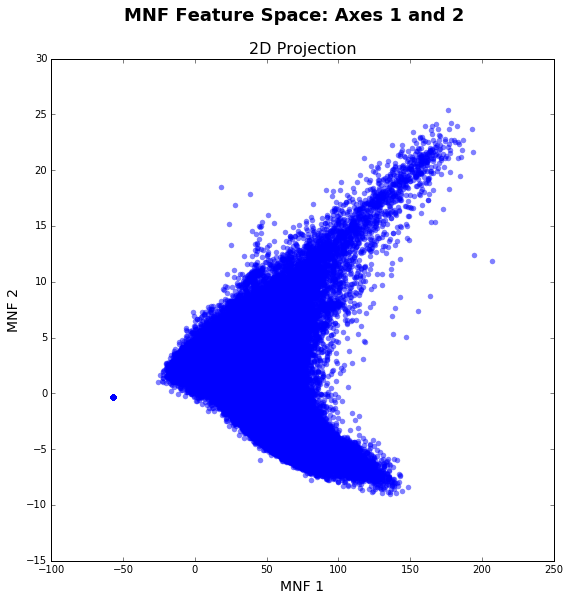

In [104]:
%matplotlib inline
from unmixing.utils import array_to_raster, dump_raster
from unmixing.visualize import FeatureSpace

# Convert array to gdal.Dataset (raster), dump to file
dump_raster(array_to_raster(lt5_image, gt, wkt), '/home/arthur/Desktop/detroit.tiff', nodata = -9999)

# Set feature_limit = None so that we see every pixel, not a random subset
vis_fs = FeatureSpace(path = '/home/arthur/Desktop/detroit.tiff', nodata = -9999,
                      feature_limit = None)
vis_fs.plot_feature_space()

Here, we see the familiar triangular shape of the mixing space that we would expect. The lone dot at the left of the mixing space is where photometric shade pixels or water pixels reside--anything with zero reflectance we weren't able to mask. The closest corner of the mixing space is therefore our shade/ low-albedo endmember. The top-right corner most likely corresponds to high-albedo and the bottom-right corner to vegetation.

PPI picked endmembers for us; we can plot them to see if it did a good job.

In [ ]:
%matplotlib inline
%config InlineBackend.close_figures=False
vis_fs.plot_feature_space()

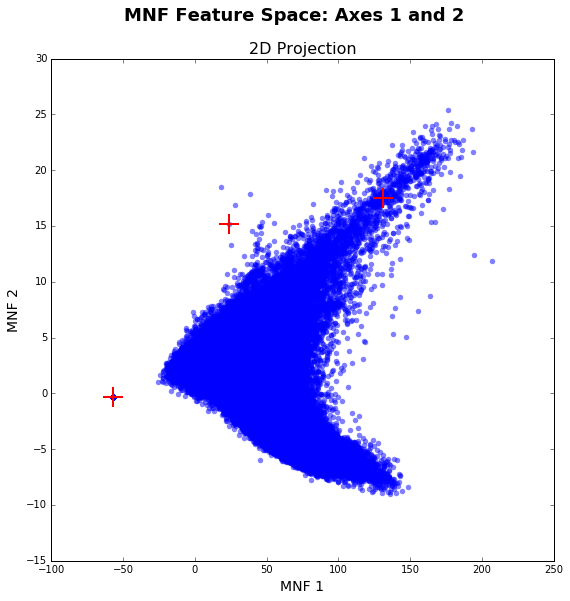

In [111]:
from unmixing.utils import spectra_at_xy

# Get MNF spectra from the HSI cube using the lat-lon coordinates
lat_lon_coords = pixel_to_xy(coords, gt = gt, wkt = wkt, dd = True)
mnf_spectra = spectra_at_xy(hsi_post_mnf.T, lat_lon_coords, gt, wkt, dd = True)
vis_fs.plot_spectral_points(mnf_spectra)
plt.show()

PPI found photometric shade/water pixels (the lower-left corner) but the other two endmembers are totally unacceptable.

### Picking from among Potential Endmembers with Graham's Scan

We've got to be able to do better than PPI. If we have a set of potential endmembers, a set of multiple examples of pure targets for each endmember type in the scene, we could determine which three endmembers (one of each type) optimize the mixing space, assuming that those that span the maximum volume are ideal (according to Yang et al. 2014).

It just so happens that for this area I have some potential endmembers that I found using Google Earth.

In [112]:
import json

with open('/home/arthur/Desktop/vegetation.json', 'r') as stream:
    veg_pifs = json.load(stream)
    
with open('/home/arthur/Desktop/bright.json', 'r') as stream:
    bright_pifs = json.load(stream)

targets = veg_pifs.copy()
targets.update(bright_pifs)
targets

{'High/Bright': [[335428, 4701442],
  [316708, 4694032],
  [316738, 4694032],
  [316708, 4694002],
  [338248, 4693132],
  [338188, 4693042],
  [337828, 4692922],
  [338218, 4692862],
  [339358, 4692652],
  [320368, 4691392],
  [320368, 4691152],
  [331558, 4689532]],
 'Vegetation': [[324958, 4699642],
  [324808, 4699492],
  [324868, 4699492],
  [324868, 4699462],
  [324838, 4699372],
  [324928, 4699132],
  [325288, 4698832],
  [324958, 4698682],
  [324988, 4698682],
  [325108, 4698682],
  [325228, 4698682],
  [325138, 4698652],
  [324958, 4698622],
  [324928, 4698532],
  [324898, 4698472],
  [325048, 4698412]]}

Graham's scan is an algorithm for finding a convex hull, which is exactly what we need here. A convex hull will be the outer-most boundary containing our potential endmembers, thereby maximizing the volume they enclose.

In [113]:
from unmixing.lsma import convex_hull_graham

# Flatten the dictionary to a list
endmember_coords = []
for target in targets.keys():
    endmember_coords.extend(targets[target])
    
# A known shade endmember
shade_em = (338358, 4692846)
endmember_coords.append(shade_em)

# Get the MNF spectra for each potential endmember
endmember_spectra = spectra_at_xy(hsi_post_mnf.T, endmember_coords, gt, wkt, dd = False)

# Find endmembers using Graham's scan
idx, hull = convex_hull_graham(endmember_spectra[...,0:2].tolist(), indices = True)

In [ ]:
plt.close()
vis_fs.plot_feature_space()

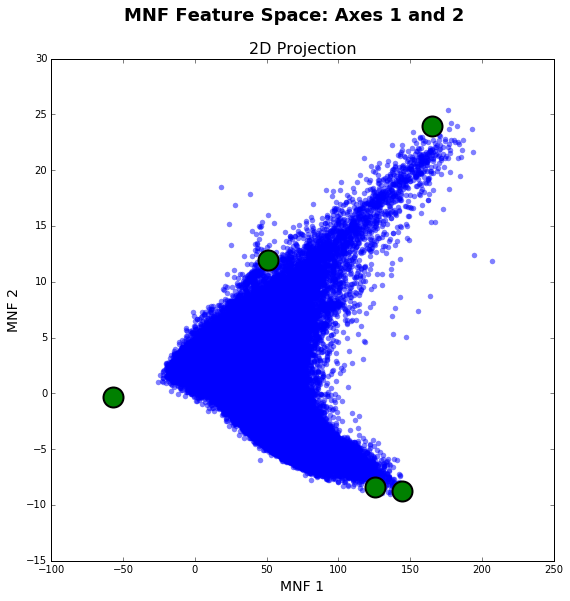

In [117]:
vis_fs.plot_spectral_points(hull, fmt = 'go')
plt.show()

Now that we have a reasonable convex hull, we can search for which group of three endmembers encloses the maximum volume.

In [ ]:
from unmixing.lsma import endmembers_by_maximum_volume

# Get the coordinate pairs that appeared in the convex hull
hull_coords = [endmember_coords[i] for i in idx]

# A follow-up search by maximum volume
ems, em_coords = endmembers_by_maximum_volume(hsi_post_mnf.T, hull_coords, 
                                              shade_em, gt = gt, wkt = wkt)

plt.close()
vis_fs.plot_feature_space()

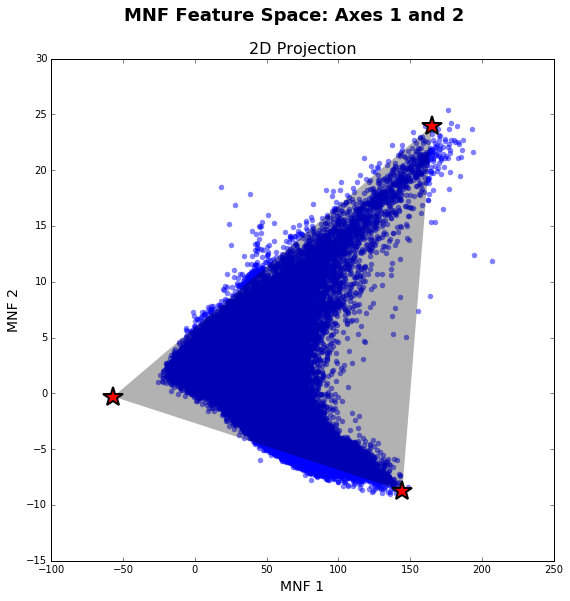

In [135]:
vis_fs.plot_spectral_points(ems, fmt='r*')
vis_fs.plot_2d_mixing_space(ems)

---
## Fully Constrained Least Squares Unmixing

We're now ready to apply fully constrained least squares (FCLS) unmixing to obtain the fractional land cover for each endmember type. FCLS models each mixed pixel as a linear combination of weighted endmember spectra (the weights correspond to the fractional amount of each endmember type present in the pixel) but with two additional constraints on the inversion:

- Non-negativity: Weights (endmember fractions) must be non-negative;
- Sum-to-one: Weights (endmember fractions) must sum to one (1) across all endmember types;

These are both very reasonable assumptions to make with LSMA; the mixed pixel is some combination of the endmember materials (e.g., vegetation, soil, impervious surface), so they must sum to one and there is no sense in talking about "negative" fractions of material present. While non-negative least squares (NNLS) relaxes the first constraint and is therefore faster to compute, FCLS generally provides more accurate estimates where these assumptions (non-negativity and sum-to-one) are true.

In [142]:
from unmixing.lsma import FCLSAbundanceMapper

mnf = mnf_rotation(lt5_image)
fcls_mapper = FCLSAbundanceMapper(mnf.T, gt, wkt, processes = 6)

We instantiate the `FCLSAbundanceMapper` class, which is a convenient tool for storing our mixed data (`lt5_image`) and all the built-in functions and tools for doing FCLS unmixing. **We want to make sure that we pass an MNF-transformed image to `FCLSAbundanceMapper` because we are going to use MNF-transformed endmembers.** Below, we verify that we have selected our endmember spectra for the three endmembers.

**The mapper supports using multiple cores for doing LSMA, so we can get the work done pretty quickly.** With the `processes = 6` argument, above we can tell the mapper to use 6 processes/ CPUs to get the work done. The input image will be spatially decomposed into 6 domains that are processed independently. There is also a pixel-wise approach that will decompose the image into 6 sets of pixels but, generally, chunked approaches work better, so that is the default.

In [138]:
ems

array([[ -5.67633971e+01,  -2.84786599e-01,   1.05018373e-02],
       [  1.44592334e+02,  -8.70905568e+00,   2.48851821e+00],
       [  1.65189512e+02,   2.39555235e+01,   6.04995199e+00]])

In [139]:
ems.shape

(3, 3)

In [143]:
result = fcls_mapper.map_abundance(ems)

Note that the resulting abundance image is in HSI form, $(M \times N \times P)$ shape.

In [149]:
result.shape

(1032, 707, 3)

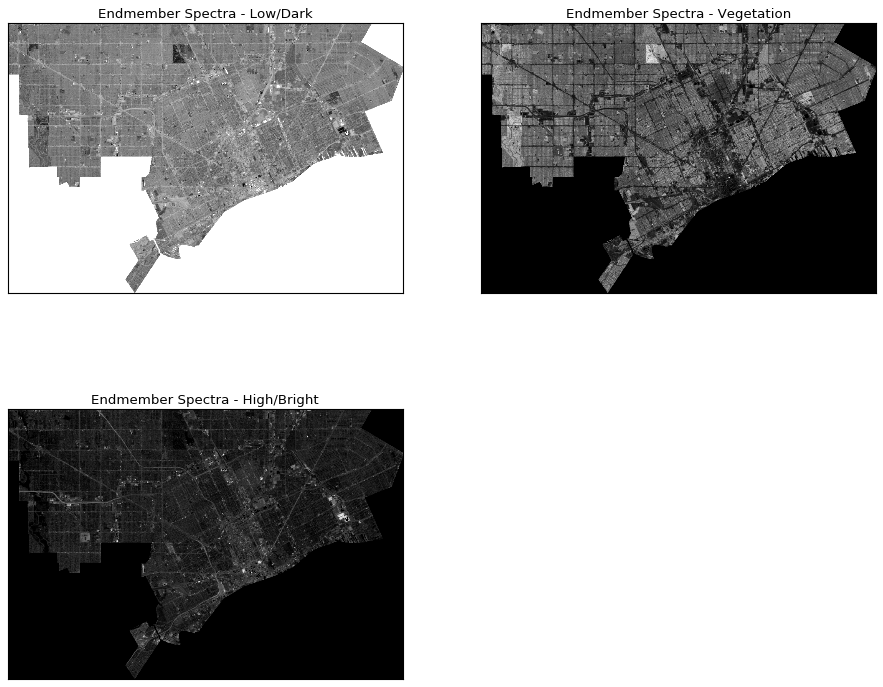

In [145]:
fig = plt.figure(figsize = (14, 14))
fig.subplots_adjust(hspace = -0.2)
endmember_labels = ['Low/Dark', 'Vegetation', 'High/Bright']
for i in range(0, 3):
    ax = fig.add_subplot(221 + i, title = 'Endmember Spectra - %s' % endmember_labels[i])
    ax.imshow(result.T[i,...], cmap = cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Shade Normalization

Because our third endmember was photometric shade (zero reflectance in all bands), we usually want to subtract the shade endmember from any other endmembers so as to obtain the real ground fraction of the other endmembers.

In [146]:
from unmixing.lsma import subtract_endmember_and_normalize

# Here, the shade endmember is the first endmember (first layer in the band axis)
result_shade_norm = subtract_endmember_and_normalize(result, e = 0)

In [147]:
result_shade_norm.shape

(1031, 707, 3)

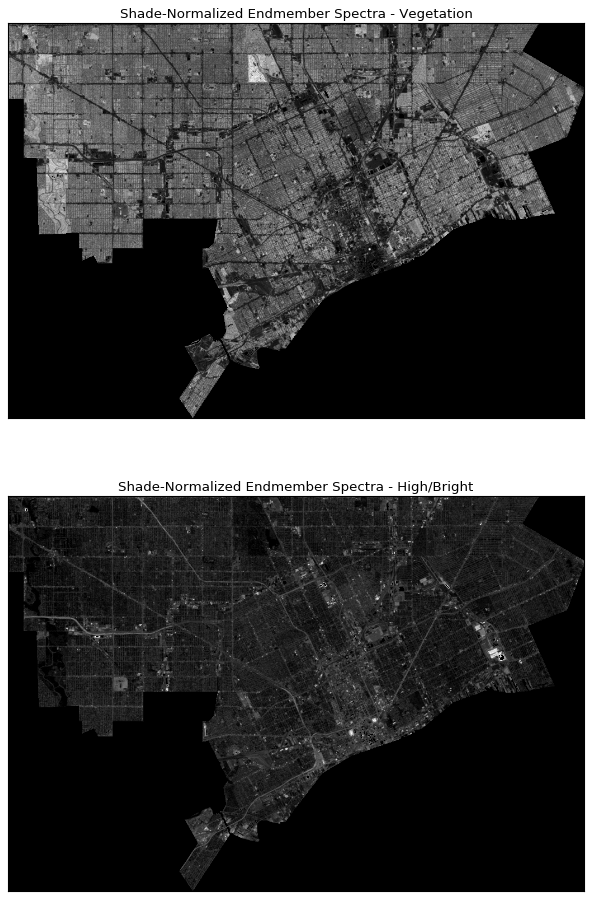

In [154]:
fig = plt.figure(figsize = (14, 14))
endmember_labels = ['Low/Dark', 'Vegetation', 'High/Bright']
for i in range(1, 3):
    ax = fig.add_subplot(210 + i, title = 'Shade-Normalized Endmember Spectra - %s' % endmember_labels[i])
    ax.imshow(result.T[i,...], cmap = cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# References

1. Hall, F. G., D. E. Strebel, J. E. Nickeson, and S. J. Goetz. 1991. Radiometric rectification: Toward a common radiometric response among multidate, multisensor images. *Remote Sensing of Environment* 35 (1):11–27.
1. Frazier, P. S., and K. J. Page. 2000. Water body detection and delineation with Landsat TM data. *Photogrammetric Engineering & Remote Sensing* 66 (12):1461–1467.
1. Lu, D., & Weng, Q. 2004. Spectral mixture analysis of the urban landscape in Indianapolis with Landsat ETM+ imagery. *Photogrammetric Engineering & Remote Sensing*, 70 (9):1053–1062.
1. Small, C. 2004. The Landsat ETM+ spectral mixing space. *Remote Sensing of Environment*, 93 (1-2):1–17.
1. Small, C., and C. Milesi. 2013. Multi-scale standardized spectral mixture models. *Remote Sensing of Environment* 136:442–454.
1. Yang, J., Y. He, and T. Oguchi. 2014. An endmember optimization approach for linear spectral unmixing of fine-scale urban imagery. *International Journal of Applied Earth Observation and Geoinformation* 27:137–146.